In [2]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

This jupyter notebooks aims at plotting the evolution of the train and validation loss during training, based on the lines printed in the terminal.

In [204]:
def get_learning_curves(text, batch_size) : 
    lines = text.split("\n")
    val_per_epoch = {"global":[], "first":[], "second":[]}
    # val_detailed = []
    train_per_epoch = {"global":[], "first":[], "second":[]}
    train_detailed = {"global":[], "first":[], "second":[]}
    detailed_x = []
    accumulated_x_from_previous_batch = 0
    epoch_x = []
    train = True
    triple_mode = None
    for line in lines :
        if line.startswith("Training"):
            train = True
        elif line.startswith("Evaluation"):
            accumulated_x_from_previous_batch = detailed_x[-1]
            train = False
        elif line.startswith("Evaluate [") or line.startswith("Train [") : 
            losses = line.split("\t")[1:]
            if len(losses) == 1 : 
                triple_mode = False
                if train : 
                    
                    batch_idx = int(line.split("[")[1].split("/")[0])
                    if batch_idx != 0 : 
                        train_detailed["global"].append(float(losses[0]))
                        detailed_x.append(accumulated_x_from_previous_batch + (batch_idx + 1) * batch_size) 
                    
                else : 
                    pass
                    # the model doesn't evolve during the eval phase so we don't care about these intermediates ?
            else :
                triple_mode = True
                if train : 
                    batch_idx = int(line.split("[")[1].split("/")[0])
                    if batch_idx != 0 :
                        train_detailed["global"].append(float(losses[0]))
                        train_detailed["first"].append(float(losses[1]))
                        train_detailed["second"].append(float(losses[2]))
                        detailed_x.append(accumulated_x_from_previous_batch + (batch_idx + 1) * batch_size) 
                    
                
        elif line.startswith("epoch:") :
            epoch_x.append(detailed_x[-1])
            if not triple_mode : 
                train_per_epoch["global"].append(float(line.split(":")[2].split(" ")[1]))
                val_per_epoch["global"].append(float(line.split(":")[3]))
            else : 
                [glob, first, second] = line.split(":")[2].split(" ")[1].split("\t")
                train_per_epoch["global"].append(float(glob))
                train_per_epoch["first"].append(float(first))
                train_per_epoch["second"].append(float(second))
                [glob, first, second] = line.split(":")[3].split(" ")[1].split("\t")
                val_per_epoch["global"].append(float(glob))
                val_per_epoch["first"].append(float(first))
                val_per_epoch["second"].append(float(second))
    return detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch

#### First experiment

The graph below is from a first experiment in which we trained two distill gpt2 models from scratch : one using a classical cross entropy loss, the other using the knowledge distillation loss. However, we didn't retrieve the detail between the first and second loss during this experiment, which makes it harder to interpret. Moreover, we used a standard [gpt2](https://huggingface.co/gpt2) from hugging face, which was trained on WebText and not on the Alpaca dataset we used. This is not recommended, and is the reason why this graph didn't make it in the final article.

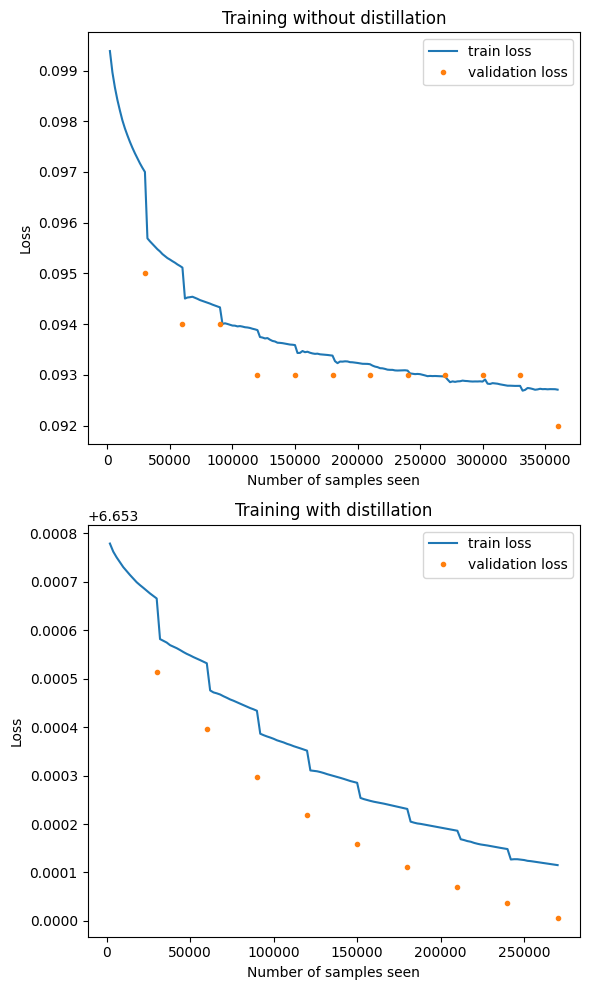

In [205]:
with open("no-distillation.out", "r") as f : 
    no_distillation = f.read()

with open("print-distillation.out", "r") as f : 
    distillation = f.read()

fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(6, 10), tight_layout=True)

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(no_distillation, batch_size=2)
ax1.plot(detailed_x, train_detailed["global"], label="train loss")
ax1.plot(epoch_x, val_per_epoch["global"], ".", label="validation loss")
ax1.legend()
ax1.set_xlabel("Number of samples seen")
ax1.set_ylabel("Loss")
ax1.set_title("Training without distillation")

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(distillation, batch_size=2)
ax2.plot(detailed_x, train_detailed["global"], label="train loss")
ax2.plot(epoch_x, val_per_epoch["global"], ".", label="validation loss")
ax2.legend()
ax2.set_xlabel("Number of samples seen")
ax2.set_ylabel("Loss")
ax2.set_title("Training with distillation")

plt.show()

#### Second experiment

The graphs below are from our experiment in which two [distilgpt2](https://huggingface.co/distilgpt2) models that were pretrained on the OpenWebTextCorpus were fine tuned on the Alpaca dataset. As previously, the first model is trained using a classical cross entropy loss, the second one using the knowledge distillation loss.

This time, we retrieved the evolution of the two terms composing the distillation loss, allowing for more complete graphs.

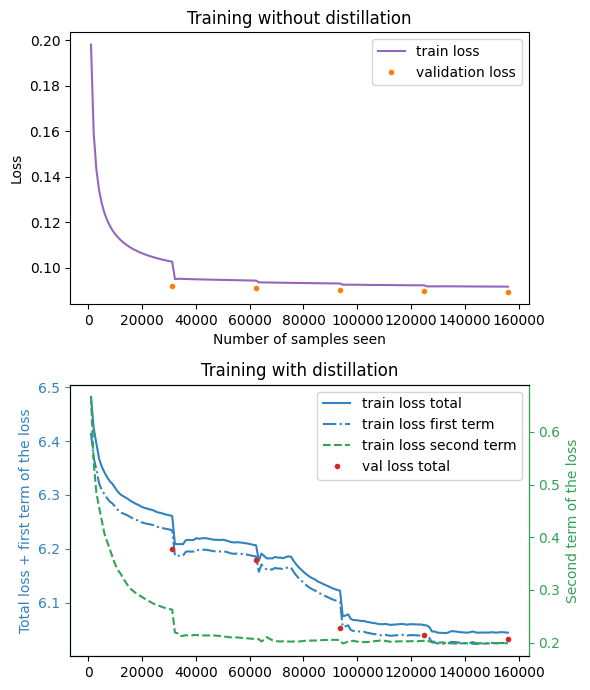

In [208]:
fig, [ax0, ax1] = plt.subplots(nrows=2, figsize=(6, 7), tight_layout=True)

with open("no_distill_new.out", "r") as f : 
    no_distill_new = f.read()

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(no_distill_new, batch_size=2)
ax0.plot(detailed_x, train_detailed["global"], label="train loss", color="tab:purple")
ax0.plot(epoch_x, val_per_epoch["global"], ".", label="validation loss", color="tab:orange")
ax0.legend()
ax0.set_xlabel("Number of samples seen")
ax0.set_ylabel("Loss")
ax0.set_title("Training without distillation")


with open("distill_new.out", "r") as f : 
    distill_new = f.read()

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(distill_new, batch_size=2)

main_color = colormaps["tab20c"](0)
second_color = colormaps["tab20c"](8)


ax2 = ax1.twinx()
line1 = ax1.plot(detailed_x, train_detailed["global"], label="train loss total", color=main_color)
line2 = ax1.plot(detailed_x, train_detailed["first"], '-.', label="train loss first term", color=main_color)
line4 = ax1.plot(epoch_x, val_per_epoch["global"], '.', label="val loss total", color="tab:red")
# line5 = ax1.plot(epoch_x, val_per_epoch["first"], 'x', label="val loss first term", color="tab:orange")
ax1.set_ylabel("Total loss + first term of the loss")
ax1.spines["left"].set_edgecolor(main_color)
ax1.yaxis.label.set_color(main_color)
ax1.tick_params(axis='y', colors=main_color)

line3 = ax2.plot(detailed_x, train_detailed["second"], '--', label="train loss second term", color=second_color)
# line6 = ax2.plot(epoch_x, val_per_epoch["second"], 'v', label="val loss second term", color="tab:orange")
ax2.spines["right"].set_edgecolor(second_color)
ax2.yaxis.label.set_color(second_color)
ax2.tick_params(axis='y', colors=second_color)
ax2.set_ylabel("Second term of the loss")

# merge legends of two axes
lns = line1+line2+line3+line4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.xlabel("Number of samples seen")
plt.title("Training with distillation")
plt.show()

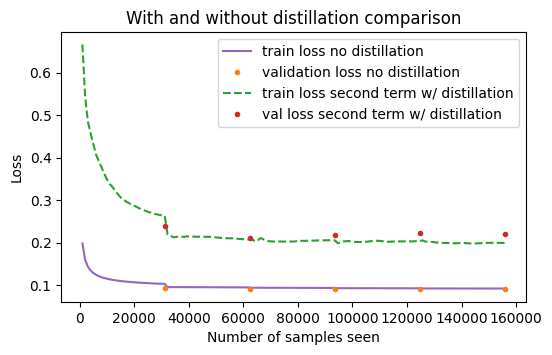

In [209]:
with open("no_distill_new.out", "r") as f : 
    no_distill_new = f.read()

with open("distill_new.out", "r") as f : 
    distill_new = f.read()

fig, ax = plt.subplots(figsize=(6,3.5))

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(no_distill_new, batch_size=2)
ax.plot(detailed_x, train_detailed["global"], label="train loss no distillation", color="tab:purple")
ax.plot(epoch_x, val_per_epoch["global"], ".", label="validation loss no distillation", color="tab:orange")

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(distill_new, batch_size=2)
ax.plot(detailed_x, train_detailed["second"], '--', label="train loss second term w/ distillation", color="tab:green")
ax.plot(epoch_x, val_per_epoch["second"], '.', label="val loss second term w/ distillation", color="tab:red")
# ax.set_yscale('log')

ax.legend()
ax.set_xlabel("Number of samples seen")
ax.set_ylabel("Loss")
ax.set_title("With and without distillation comparison")
plt.show()

The graph below was an attempt at comparing the steepness of the two cross entropy losses by using different scales for them. However the resulting plot is confusing, so it was not used in the article.

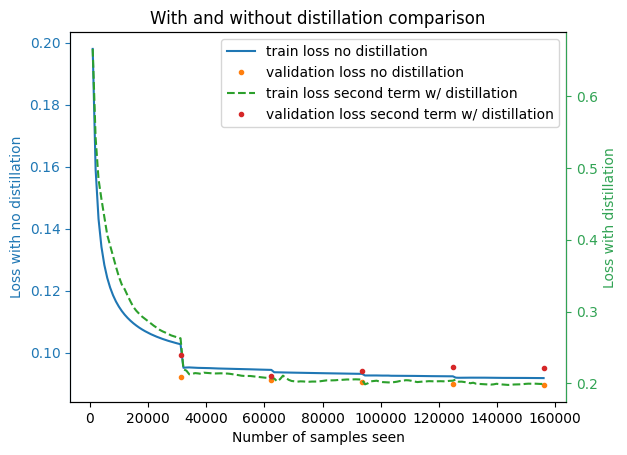

In [210]:
with open("no_distill_new.out", "r") as f : 
    no_distill_new = f.read()

with open("distill_new.out", "r") as f : 
    distill_new = f.read()

fig, ax = plt.subplots()
ax2 = ax.twinx()

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(no_distill_new, batch_size=2)
line1 = ax.plot(detailed_x, train_detailed["global"], label="train loss no distillation")
line2 = ax.plot(epoch_x, val_per_epoch["global"], ".", label="validation loss no distillation")
ax.spines["left"].set_edgecolor("tab:blue")
ax.yaxis.label.set_color("tab:blue")
ax.tick_params(axis='y', colors="tab:blue")
ax.set_ylabel("Loss with no distillation")

detailed_x, train_detailed, epoch_x, train_per_epoch, val_per_epoch = get_learning_curves(distill_new, batch_size=2)
line3 = ax2.plot(detailed_x, train_detailed["second"], '--', label="train loss second term w/ distillation", color="tab:green")
line4 = ax2.plot(epoch_x, val_per_epoch["second"], '.', label="validation loss second term w/ distillation", color="tab:red")
ax2.spines["right"].set_edgecolor(second_color)
ax2.yaxis.label.set_color(second_color)
ax2.tick_params(axis='y', colors=second_color)
ax2.set_ylabel("Loss with distillation")

lns = line1+line2+line3+line4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
ax.set_xlabel("Number of samples seen")
ax.set_title("With and without distillation comparison")
plt.show()